# PROJECT STOCK PRICE PREDICTION (GOOGLE STOCK PRICE)
ROMIT RAJ  
2011MT16  
MTECH MECHATRONICS


preparing notebook and Importing libraries

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 22.8MB/s 
     |████████████████████████████████| 9.5MB 37.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
#import packages
import pandas as pd
import numpy as np
from numpy import array
from pandas_datareader import data as pdr
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

Loading dataset

In [ ]:
googl = pdr.DataReader('googl', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30))
googl.to_csv('Google_stock.csv', sep=',')
googl = googl.reset_index()

In [ ]:
googl.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2014-08-01,583.429993,570.299988,578.549988,573.599976,2213300,573.599976
1,2014-08-04,583.820007,572.260010,576.510010,582.270020,1519400,582.270020
2,2014-08-05,580.200012,570.309998,579.380005,573.140015,1643800,573.140015
3,2014-08-06,578.640015,567.450012,569.500000,574.489990,1322800,574.489990
4,2014-08-07,578.309998,569.429993,576.049988,571.809998,1163000,571.809998


Visualizing data

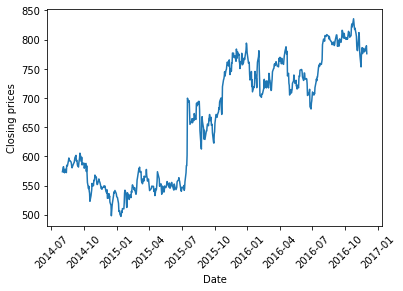

In [ ]:
plt.plot(googl["Date"],googl["Close"])
plt.xlabel('Date')
plt.ylabel('Closing prices')
plt.xticks(rotation=45)
plt.show()

<Figure size 432x288 with 0 Axes>

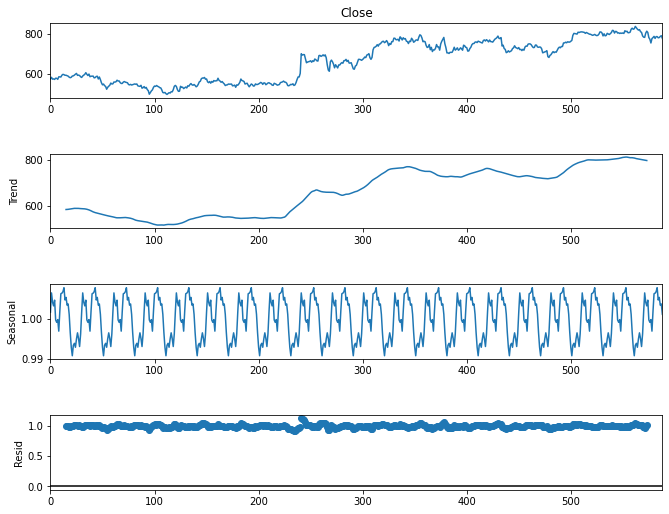

In [ ]:
result = seasonal_decompose(googl["Close"], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 8)

checks for Stationarity

In [ ]:
def adf_test(atr):
  timeseries = googl[atr].dropna()
  print ('Results of Dickey-Fuller Test for ',atr,'\n')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

adf_test('Close')

Results of Dickey-Fuller Test for  Close 

Test Statistic                  -1.092577
p-value                          0.718023
#Lags Used                       3.000000
Number of Observations Used    585.000000
Critical Value (1%)             -3.441578
Critical Value (5%)             -2.866493
Critical Value (10%)            -2.569408
dtype: float64


In [ ]:
#define KPSS
def kpss_test(atr,**kw):
  timeseries = googl[atr].dropna()
  print ('Results of KPSS Test for ',atr)
  kpsstest = kpss(timeseries, regression = "ct")
  kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
  for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
  print (kpss_output)
kpss_test('Close')

Results of KPSS Test for  Close
Test Statistic            0.232866
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


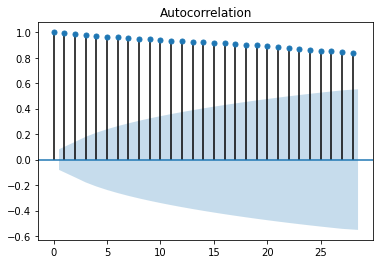

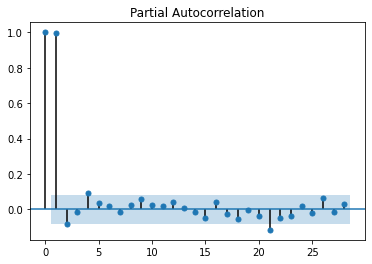

In [ ]:
# plot acf and pacf graph
plot_acf(googl['Close'])
plot_pacf(googl['Close'])
plt.show()

From ADF TEST, p value is more than 0.05 so the data is NON STATIONARY.

and also from acf and pacf plot we can see non stationarity in data.

Convert into stationary with 1st differencing

In [ ]:
googl['diff'] = googl['Close'].diff(periods=1)

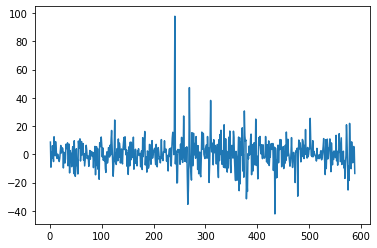

In [ ]:
googl["diff"].plot()

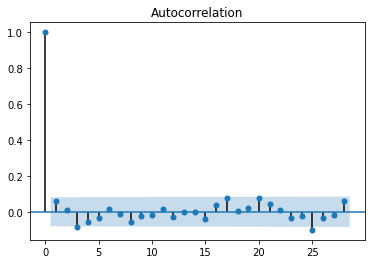

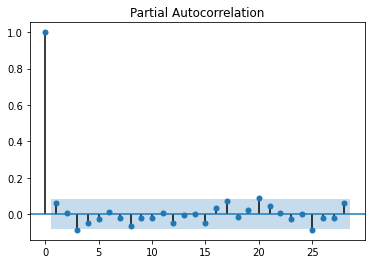

In [ ]:
plot_acf(googl['diff'].dropna())
plot_pacf(googl['diff'].dropna())
plt.show()

from ACF and PACF plots sationarity can be noticed as all the lags aprroximately within confidence level.

Preparing data

In [ ]:
n = int(len(googl["Close"])*0.8)
train = googl.Close[:n]
test = googl.Close[n:]

### MODEL 1: TRIPLE EXPONENTIAL SMOOTHING

In [ ]:
model = ExponentialSmoothing(test,trend='mul',seasonal='mul',seasonal_periods=12)
yhat = model.fit(smoothing_level = 0.9,smoothing_slope= 0.1,smoothing_seasonal = 0.2).fittedvalues.shift(0)
RMSE = sqrt(mean_squared_error(test, yhat))
print("RMSE with triple exponential smoothing :",RMSE)

RMSE with triple exponential smoothing : 9.064061128302946


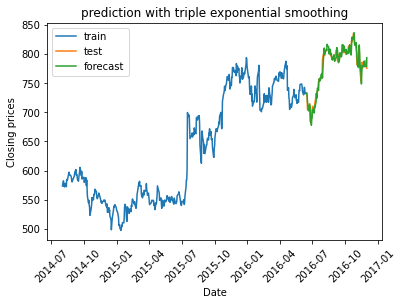

In [ ]:
plt.title("prediction with triple exponential smoothing")
plt.plot(googl.Date[:n],train,label = "train")
plt.plot(googl.Date[n:],test,label = "test")
plt.plot(googl.Date[n:],yhat,label = "forecast")
plt.xlabel('Date')
plt.ylabel('Closing prices')
plt.xticks(rotation=45)
plt.legend()

### MODEL 2: ARIMA

In [ ]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(googl["Close"], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=1,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4378.078, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4376.378, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4376.081, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4376.132, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4375.078, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.741 seconds
4375.078050332457


In [ ]:
# fit model
model = ARIMA(googl["Close"], order=(1, 1, 0))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(train), len(train)+len(test)-1)
RMSE = sqrt(mean_squared_error(test, yhat))
print("RMSE with ARIMA(1,1,0) :",RMSE)

RMSE with ARIMA(1,1,0) : 8.399911760806532


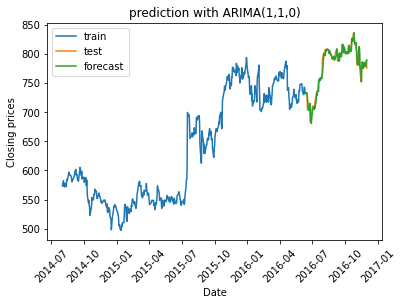

In [ ]:
plt.title("prediction with ARIMA(1,1,0)")
plt.plot(googl.Date[:n],train,label = "train")
plt.plot(googl.Date[n:],test,label = "test")
plt.plot(googl.Date[n:],yhat,label = "forecast")
plt.xlabel('Date')
plt.ylabel('Closing prices')
plt.xticks(rotation=45)
plt.legend()

### MODEL 3: LSTM

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
raw_seq = googl['Close']
trainLen = n
train = raw_seq[:trainLen]
test = raw_seq[trainLen:]

In [ ]:
n_steps = 3
n_features = 1
X, y = split_sequence(train, n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
history = model.fit(X, y, epochs=100, verbose=0)

In [ ]:
test = test.reset_index(drop = True)

In [ ]:
# demonstrate prediction
X_test, y_test = split_sequence(test, n_steps)
X_test = np.array(X_test).reshape((-1, n_steps, n_features))
pred = model.predict(X_test, verbose=0)
yhat = pd.DataFrame(pred,googl.Date[n+3:])

In [ ]:
RMSE = sqrt(mean_squared_error(y_test, pred))
print("RMSE with LSTM :",RMSE)

RMSE with LSTM : 11.168989435410529


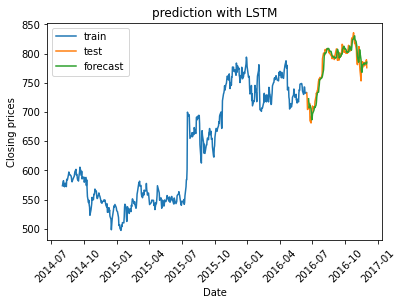

In [ ]:
plt.title("prediction with LSTM")
plt.plot(googl.Date[:n],train,label = "train")
plt.plot(googl.Date[n:],test,label = "test")
plt.plot(yhat,label = "forecast")
plt.xlabel('Date')
plt.ylabel('Closing prices')
plt.xticks(rotation=45)
plt.legend()

### CONCLUSION
RMSE with ARIMA(0,1,0) : 9.064

RMSE with triple exponential smoothing : 8.428 

RMSE with LSTM : 10.067

So triple exponential smoothing models predicts better than other too models.
